In [10]:
import wget
import pandas as pd
import os
filename = wget.download('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df1 = pd.read_csv(filename)
os.remove(filename)

filename = wget.download('https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv')
df2 = pd.read_csv(filename)
os.remove(filename)



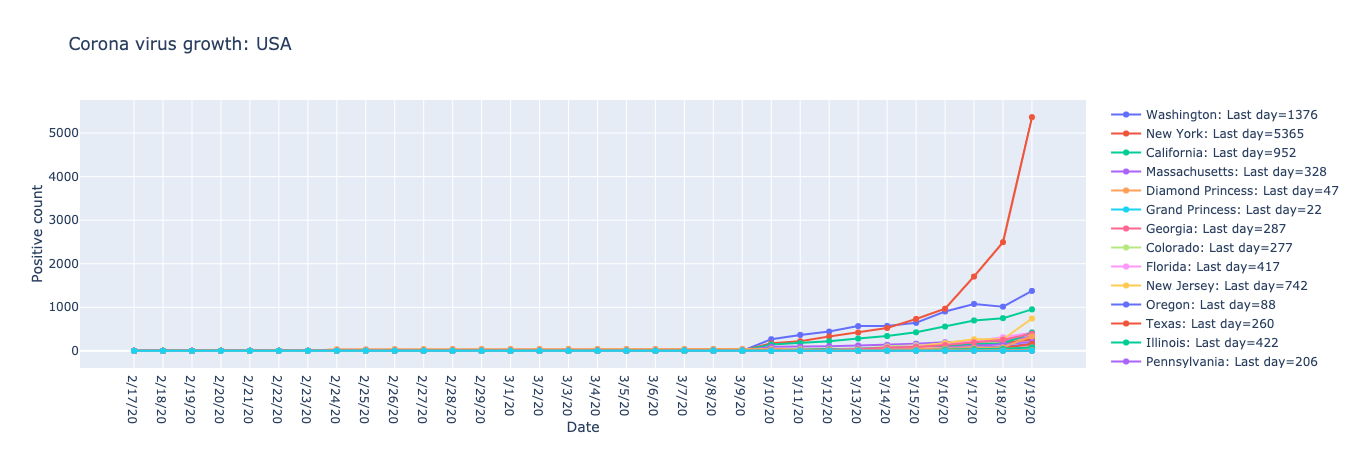

'corona_us.html'

In [14]:
import plotly.graph_objects as go
import numpy as np
import plotly

df = df1
dfUS = df[df['Country/Region']=='US']
states = dfUS['Province/State'].unique()

fig = go.Figure()

for state in states:
    time = list(df.columns)[30:]
    count = list(df[df['Province/State']==state].to_numpy()[0][30:])
    last_count = count[-1]
    if last_count > 0:
        fig.add_trace(
            go.Scatter(
                x=time, y=count, mode='lines+markers', name=state+f': Last day={last_count}',
                hoverinfo='text',
                hovertext=[f'{state}, {t}, count={c}' for t,c in zip(time,count)]
            )
        )
    
fig.update_layout(
    title="Corona virus growth: USA",
    xaxis_title="Date",
    yaxis_title="Positive count",
)
fig.show()

plotly.offline.plot(fig, filename = 'corona_us.html', auto_open=False)

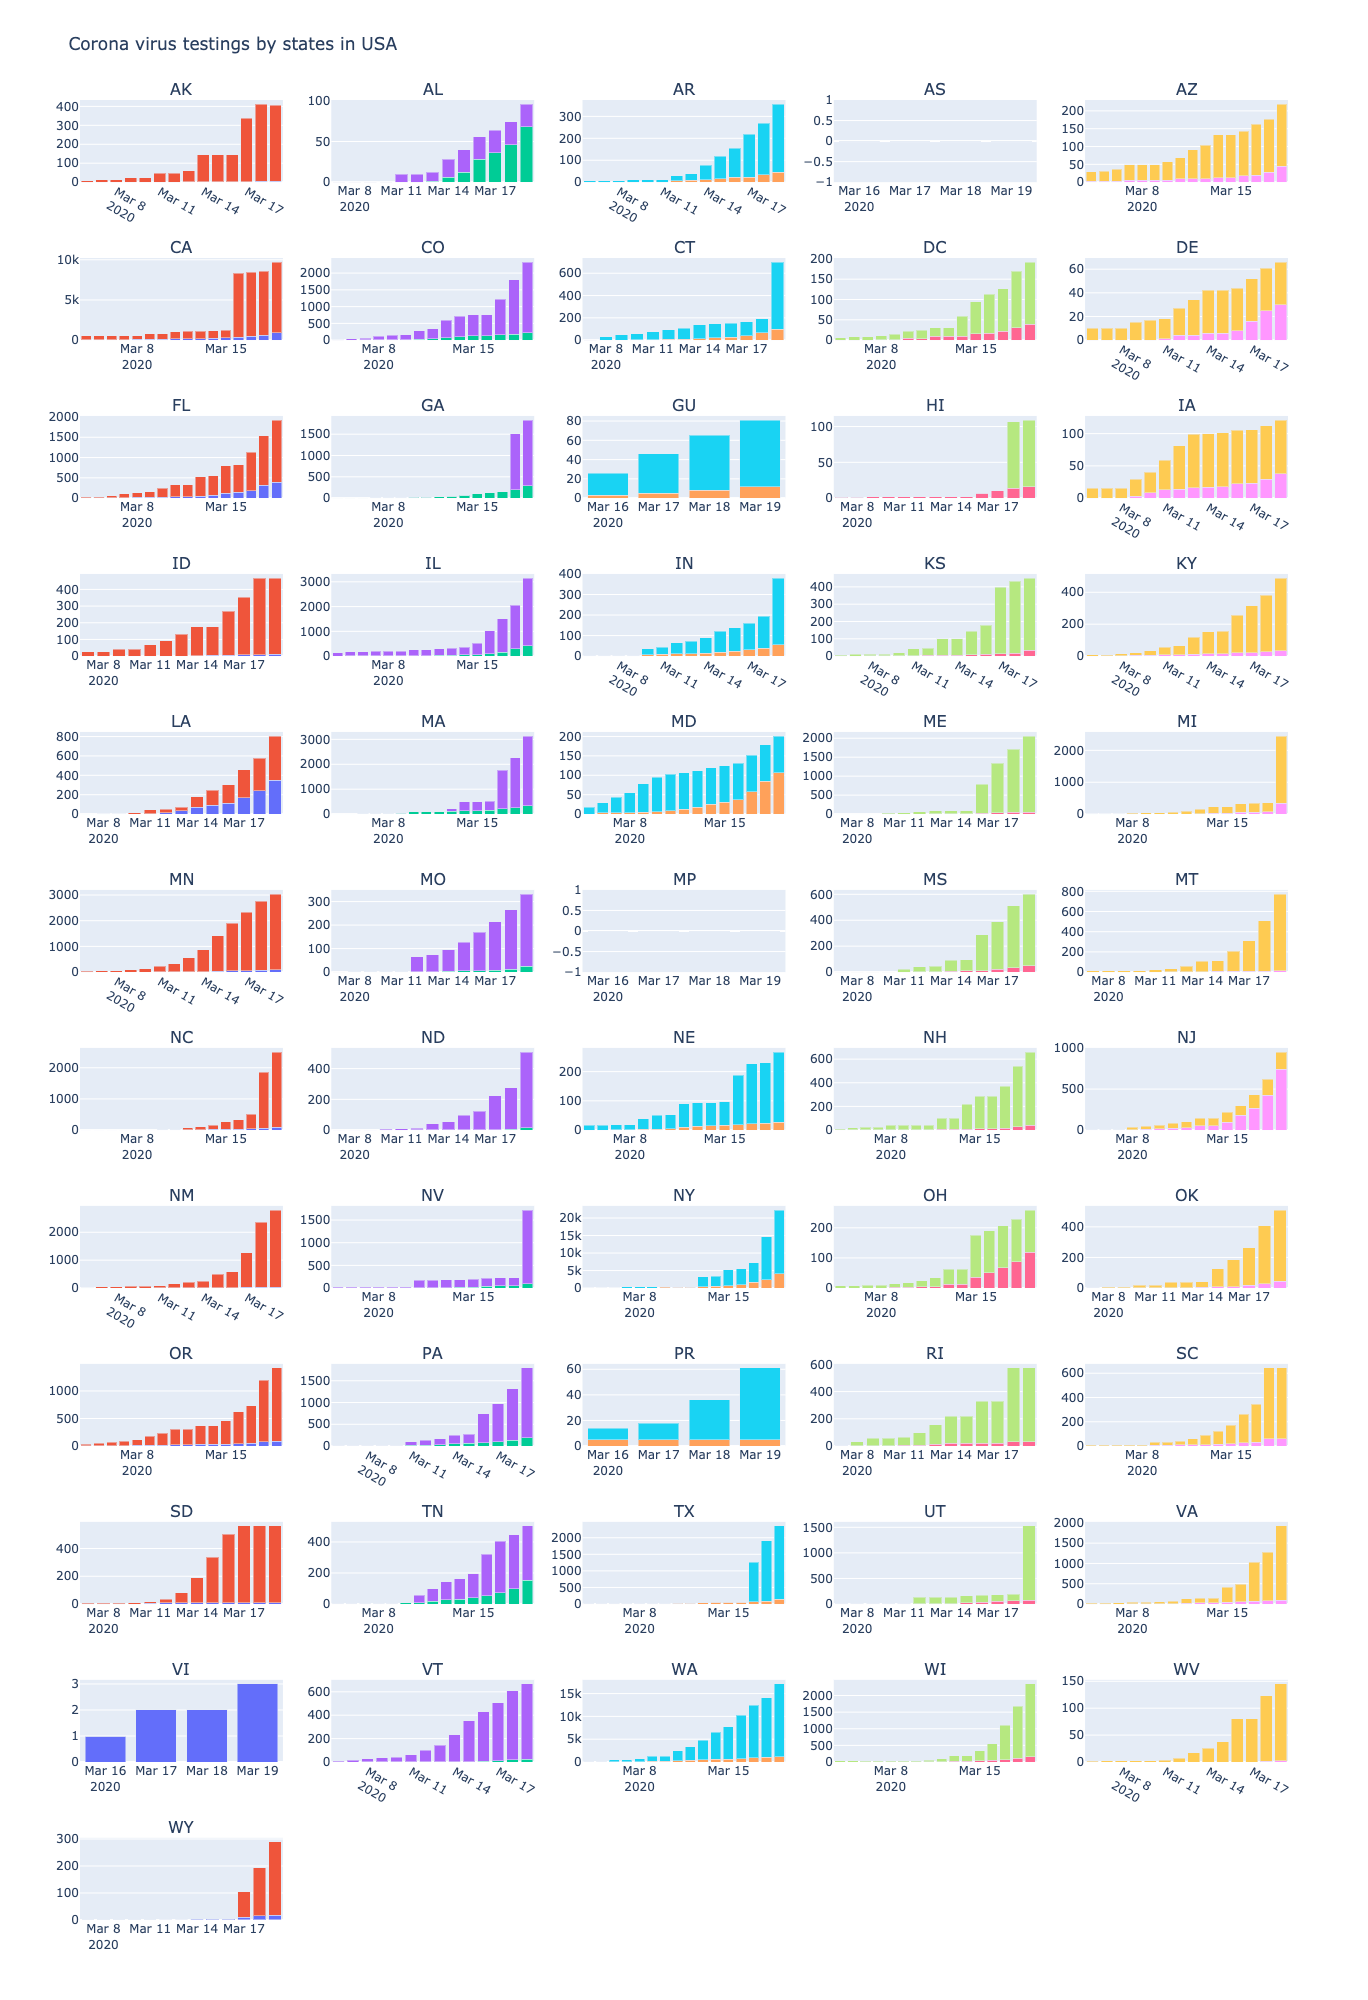

'corona_states.html'

In [12]:
import numpy as np

df = df2
states = df.state.unique()

from plotly.subplots import make_subplots

total_cols = 5
total_rows = int(len(states)/total_cols) + 1

fig = make_subplots(rows=total_rows, cols=total_cols, subplot_titles=states)
bars = dict()
for idx, state in enumerate(states):
    dfstate = df[df.state == state]
    dfstate = dfstate.sort_values(by='date')
    
    dates, positives, negatives = [],[],[]
    for idx, row in dfstate.iterrows():
        date, positive, negative = str(row.date), row.positive, row.negative
        if str(positive) == 'nan':
            positive = 0
        if str(negative)=='nan':
            negative = 0
        dates.append(pd.Timestamp(date))
        positives.append(positive)
        negatives.append(negative)
    data=[
        go.Bar(x=dates, y=positives, hovertext=['pos:'+str(int(p)) for p in positives]),
        go.Bar(x=dates, y=negatives, hovertext=['neg:'+str(int(n)) for n in negatives])
    ]
    
    cols = total_cols
    i, j = int(idx/cols)+1, idx%cols+1
    fig.add_trace(data[0], row=i, col=j)
    fig.add_trace(data[1], row=i, col=j)
fig.update_layout(barmode='stack', height=2000, showlegend=False, title_text='Corona virus testings by states in USA')
fig.show()
plotly.offline.plot(fig, filename = 'corona_states.html', auto_open=False)